In [3]:
import tensorflow as tf
import numpy as np
import random
import os

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import time

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 79.4M/79.4M [00:00<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1


# Data Preprocessing

In [7]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.4
)

train_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    path + '/test',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=False,
    seed=SEED
)

Found 7128 images belonging to 2 classes.
Found 4751 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


# EDA

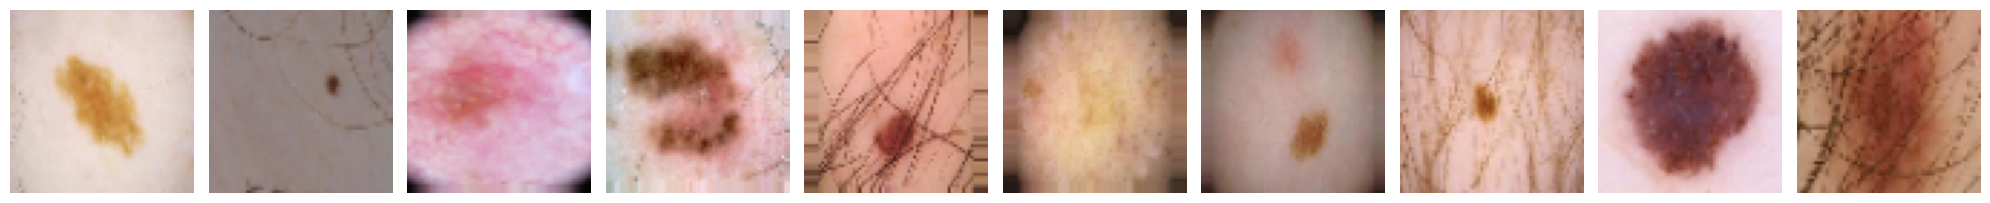

In [8]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Function to display images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 10 images from the batch
plot_images(images[:10])

# Hyper Parameters Tuning

## Model Evaluation Function

In [9]:
def evaluate_model(
    filters1, filters2, dropout1, dropout2,
    learning_rate, activation, last_activation,
    keep_model=False
):
    model = models.Sequential([
        layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation,
                      input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(units=128, activation=activation),
        layers.Dropout(dropout1),
        layers.Dense(units=64, activation=activation),
        layers.Dropout(dropout2),
        layers.Dense(units=1, activation=last_activation)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=4,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        verbose=0
    )

    val_acc = history.history["val_accuracy"][-1]

    # ===== MEMORY SAFE CLEANUP =====
    if not keep_model:
        tf.keras.backend.clear_session()
        del model
        del history
        del optimizer
        return val_acc, None, None
    # ===============================

    return val_acc, model, history


## Search Space Initialization

In [10]:
search_space = {}
search_space['filters1'] = [32, 64, 128]
search_space['filters2'] = [32,64,128]
search_space['dropout1'] = [0.1, 0.3, 0.5, 0.7]
search_space['dropout2'] = [0.1, 0.3, 0.5, 0.7]
search_space['learning_rate'] = [0.0001, 0.001, 0.01, 0.1]
search_space['activation'] = ['relu', 'elu', 'gelu']
search_space['last_activation'] = ['sigmoid']

## Neighborhood Generation

In [11]:
def _immediate_neighbours(index, dimension, state):
    neighbours = []
    vals = search_space[dimension]
    new_state_base = list(state)  # Convert tuple to list for modification

    if index == 0:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[1]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[2]
        neighbours.append(tuple(neigh_state))
    elif index == len(vals) - 1:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[-2]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[-3]
        neighbours.append(tuple(neigh_state))
    else:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[index - 1]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[index + 1]
        neighbours.append(tuple(neigh_state))

    return neighbours

def get_neighbours(state):
    neighbours = []
    state_dict = {k: state[i] for i, k in enumerate(search_space.keys())}

    for k in search_space.keys():
        if k in ['activation', 'last_activation']:
            continue
        index = search_space[k].index(state_dict[k])
        new_neighbours = _immediate_neighbours(index, k, state)
        neighbours.extend(new_neighbours)

    # Add a neighbor with random activation and last_activation
    new_state = list(state)
    new_state[5] = np.random.choice(search_space['activation'])
    new_state[6] = np.random.choice(search_space['last_activation'])
    neighbours.append(tuple(new_state))

    return neighbours

# Whale Algorithm

In [ ]:
def whale_search(max_iter=3, population_size=3, b=1.0):
    print(f"  -> WOA Start (Pop={population_size}, Iter={max_iter}, b={b})")
    keys = list(search_space.keys())
    population = []
    for _ in range(population_size):
        w = (
            random.choice(search_space["filters1"]),
            random.choice(search_space["filters2"]),
            random.choice(search_space["dropout1"]),
            random.choice(search_space["dropout2"]),
            random.choice(search_space["learning_rate"]),
            random.choice(search_space["activation"]),
            random.choice(search_space["last_activation"])
        )
        population.append(w)

    scores = []
    # --- Evaluate Initial Population ---
    for w in population:
        # keep_model=False ensures we don't return the heavy object
        acc, _, _ = evaluate_model(*w, keep_model=False)
        scores.append(acc)
        # CLEANUP
        tf.keras.backend.clear_session()
        gc.collect()

    best_index = int(np.argmax(scores))
    best_state = population[best_index]
    best_score = scores[best_index]

    for t in range(max_iter):
        a = 2 - 2 * (t / max_iter)
        new_population = []

        for i in range(population_size):
            whale = population[i]
            p = random.random()
            # Convert categorical params to indices for math operations
            whale_indices = [
                search_space["filters1"].index(whale[0]),
                search_space["filters2"].index(whale[1]),
                search_space["dropout1"].index(whale[2]),
                search_space["dropout2"].index(whale[3]),
                search_space["learning_rate"].index(whale[4])
            ]

            best_indices = [
                search_space["filters1"].index(best_state[0]),
                search_space["filters2"].index(best_state[1]),
                search_space["dropout1"].index(best_state[2]),
                search_space["dropout2"].index(best_state[3]),
                search_space["learning_rate"].index(best_state[4])
            ]

            updated_indices = []

            # Update numeric parameters (first 5 params)
            for dim in range(len(whale_indices)):
                r1 = random.random()
                r2 = random.random()
                A = 2 * a * r1 - a
                C = 2 * r2

                val = 0

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_indices[dim] - whale_indices[dim])
                        val = best_indices[dim] - A * D
                    else:
                        # Search for prey (exploration)
                        rand_idx = random.randint(0, population_size - 1)
                        rand_whale = population[rand_idx]
                        rand_val_idx = random.randint(0, len(search_space[keys[dim]]) - 1)
                        D = abs(C * rand_val_idx - whale_indices[dim])
                        val = rand_val_idx - A * D
                else:
                    # Spiral updating
                    D_prime = abs(best_indices[dim] - whale_indices[dim])
                    l = random.uniform(-1, 1)
                    val = D_prime * math.exp(b * l) * math.cos(2 * math.pi * l) + best_indices[dim]

                val = int(round(val))
                val = max(0, min(val, len(search_space[keys[dim]]) - 1))
                updated_indices.append(val)

            new_state = (
                search_space["filters1"][updated_indices[0]],
                search_space["filters2"][updated_indices[1]],
                search_space["dropout1"][updated_indices[2]],
                search_space["dropout2"][updated_indices[3]],
                search_space["learning_rate"][updated_indices[4]],
                random.choice(search_space["activation"]),      # Randomly mutated
                random.choice(search_space["last_activation"])  # Randomly mutated
            )
            new_population.append(new_state)

        # --- Evaluate New Positions ---
        new_scores = []
        for w in new_population:
            acc, _, _ = evaluate_model(*w, keep_model=False)
            new_scores.append(acc)

            # CLEANUP
            tf.keras.backend.clear_session()
            gc.collect()

        # Check for improvement in this batch
        iteration_best_index = int(np.argmax(new_scores))
        iteration_best_score = new_scores[iteration_best_index]
        iteration_best_state = new_population[iteration_best_index]

        if iteration_best_score > best_score:
            best_score = iteration_best_score
            best_state = iteration_best_state

        population = new_population

    print(f"  -> WOA Finished. Best Score: {best_score:.4f}")

    return best_state, best_score

# Hill Climbing For Whale Algorithm

In [ ]:
def hill_climbing_for_woa():
    print("===== HILL CLIMBING FOR WOA (Optimizing 'b' only) =====")
    fixed_pop = 3
    fixed_iter = 3

    #Search space for 'b' (Spiral constant)
    b_candidates = np.linspace(0.5, 2.5, 5)

    #Random Start
    current_b = float(random.choice(b_candidates))
    current_woa_params = (fixed_pop, fixed_iter, current_b)

    print(f"Fixed Population: {fixed_pop}")
    print(f"Fixed Iterations: {fixed_iter}")
    print(f"Initial Spiral constant b: {current_b:.2f}")
    print("=" * 60)

    # Initial Evaluation
    best_cnn_state, best_score = whale_search(
        max_iter=fixed_iter,
        population_size=fixed_pop,
        b=current_b
    )

    best_woa_params = current_woa_params
    improved = True
    iteration = 0

    while improved:
        iteration += 1
        improved = False

        print(f"\n--- HC Iteration {iteration} ---")
        print(f"Current WOA params: {best_woa_params}")
        print(f"Current Best Accuracy: {best_score:.4f}")

        neighbours = []

        for bval in b_candidates:
            if float(bval) != best_woa_params[2]:
                neighbours.append((fixed_pop, fixed_iter, float(bval)))

        print(f"Generated {len(neighbours)} neighbours for 'b' parameter")
        print("=" * 60)

        for n in neighbours:
            print(f"Evaluating neighbour b={n[2]:.2f}")
            # Run WOA with the neighbour's 'b' value
            neigh_cnn_state, neigh_score = whale_search(
                max_iter=n[1],
                population_size=n[0],
                b=n[2]
            )

            if neigh_score > best_score:
                print(f"Improvement found: {neigh_score:.4f} > {best_score:.4f}")

                best_score = neigh_score
                best_cnn_state = neigh_cnn_state
                best_woa_params = n
                improved = True
                break
            else:
                print("No improvement")

        print("-" * 60)

    print("===== HILL CLIMBING COMPLETED =====")
    print(f"Best WOA parameters: {best_woa_params}")
    print(f"Best CNN hyperparameters found: {best_cnn_state}")
    print(f"Best accuracy: {best_score:.4f}")
    print("=" * 60)

    return best_woa_params, best_cnn_state, best_score

In [ ]:
import gc
start_time = time.time()

best_woa_params, best_cnn_state, best_score = hill_climbing_for_woa()

end_time = time.time()
print(f"Total tuning time: {end_time - start_time:.2f} seconds")


===== HILL CLIMBING FOR WOA (Optimizing 'b' only) =====
Fixed Population: 3
Fixed Iterations: 3
Initial Spiral constant b: 1.50
  -> WOA Start (Pop=3, Iter=3, b=1.5)
  -> WOA Finished. Best Score: 0.8062

--- HC Iteration 1 ---
Current WOA params: (3, 3, 1.5)
Current Best Accuracy: 0.8062
Generated 4 neighbours for 'b' parameter
Evaluating neighbour b=0.50
  -> WOA Start (Pop=3, Iter=3, b=0.5)
  -> WOA Finished. Best Score: 0.8150
Improvement found: 0.8150 > 0.8062
------------------------------------------------------------

--- HC Iteration 2 ---
Current WOA params: (3, 3, 0.5)
Current Best Accuracy: 0.8150
Generated 4 neighbours for 'b' parameter
Evaluating neighbour b=1.00
  -> WOA Start (Pop=3, Iter=3, b=1.0)
  -> WOA Finished. Best Score: 0.8148
No improvement
Evaluating neighbour b=1.50
  -> WOA Start (Pop=3, Iter=3, b=1.5)
  -> WOA Finished. Best Score: 0.8102
No improvement
Evaluating neighbour b=2.00
  -> WOA Start (Pop=3, Iter=3, b=2.0)
  -> WOA Finished. Best Score: 0.7933


In [ ]:
import gc

In [ ]:
filters1, filters2, dropout1, dropout2, learning_rate, activation, last_activation = best_cnn_state

optimized_model = models.Sequential([
    layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation=activation),
    layers.Dropout(dropout1),
    layers.Dense(units=64, activation=activation),
    layers.Dropout(dropout2),
    layers.Dense(units=1, activation=last_activation)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimized_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = optimized_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_acc = optimized_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

optimized_model.save('HC_WOA_optimized_melanoma_model.keras')
print("Final model saved as HC_WOA_optimized_melanoma_model.keras")


Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.6671 - loss: 0.6046 - val_accuracy: 0.7449 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8125 - loss: 0.3326 - val_accuracy: 0.7401 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.7816 - loss: 0.4794 - val_accuracy: 0.7574 - val_loss: 0.4782 - learning_rate: 0.0010
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7812 - loss: 0.4716 - val_accuracy: 0.7787 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.8260 - loss: 0.3953 - val_accuracy: 0.8136 - val_loss: 0.4092 - learning_rate: 0.0010
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7812 - loss: 0.3870 - val_accuracy: 0.7946 - val_loss: 0.4541 - learning_rate: 0.0010
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.8261

# Firefly

In [21]:
def firefly_search(n=5, max_iter=5, alpha=0.2, beta0=1, gamma=1):
    print(f"  -> Firefly Start (n={n}, Iter={max_iter}, alpha={alpha}, beta0={beta0}, gamma={gamma})")

    # ----- Bounds derived from search space -----
    lb = np.array([
        min(search_space['filters1']),
        min(search_space['filters2']),
        min(search_space['dropout1']),
        min(search_space['dropout2']),
        min(search_space['learning_rate'])
    ])

    ub = np.array([
        max(search_space['filters1']),
        max(search_space['filters2']),
        max(search_space['dropout1']),
        max(search_space['dropout2']),
        max(search_space['learning_rate'])
    ])

    # ----- Initialize fireflies (continuous) -----
    fireflies = np.zeros((n, 5))
    for d in range(5):
        fireflies[:, d] = np.random.uniform(lb[d], ub[d], n)

    fitness = np.zeros(n)

    # ----- Initial Evaluation -----
    for k in range(n):
        state = (
            int(round(fireflies[k, 0])),     # filters1
            int(round(fireflies[k, 1])),     # filters2
            fireflies[k, 2],                  # dropout1
            fireflies[k, 3],                  # dropout2
            fireflies[k, 4],                  # learning_rate
            'relu',                           # activation (FIXED)
            'sigmoid'                         # last_activation (FIXED)
        )

        print(
            f"    Evaluating Initial Firefly {k+1}/{n}: "
            f"F1={state[0]}, F2={state[1]}, "
            f"D1={state[2]:.2f}, D2={state[3]:.2f}, LR={state[4]:.5f}"
        )

        acc, _, _ = evaluate_model(*state, keep_model=False)
        fitness[k] = acc

        print(f"      -> Accuracy: {acc:.4f}")

        tf.keras.backend.clear_session()
        gc.collect()

    # ----- Main Loop -----
    for t in range(max_iter):
        print(f"\n--- Iteration {t+1}/{max_iter} ---")

        for i in range(n):
            for j in range(n):
                if fitness[j] > fitness[i]:
                    r = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta0 * np.exp(-gamma * r**2)
                    zeta = np.random.normal(0, 1, size=5)

                    fireflies[i] += beta * (fireflies[j] - fireflies[i]) + alpha * zeta
                    fireflies[i] = np.clip(fireflies[i], lb, ub)

                    state = (
                        int(round(fireflies[i, 0])),
                        int(round(fireflies[i, 1])),
                        fireflies[i, 2],
                        fireflies[i, 3],
                        fireflies[i, 4],
                        'relu',
                        'sigmoid'
                    )

                    print(
                        f"    Firefly {i} moved towards {j}. "
                        f"Evaluating new position..."
                    )

                    acc, _, _ = evaluate_model(*state, keep_model=False)
                    fitness[i] = acc

                    print(f"      -> New Accuracy: {acc:.4f}")

                    tf.keras.backend.clear_session()
                    gc.collect()

    best_index = int(np.argmax(fitness))

    best_state = (
        int(round(fireflies[best_index, 0])),
        int(round(fireflies[best_index, 1])),
        fireflies[best_index, 2],
        fireflies[best_index, 3],
        fireflies[best_index, 4],
        'relu',
        'sigmoid'
    )

    print(f"\n  -> Firefly Finished. Best Accuracy: {fitness[best_index]:.4f}")

    return best_state, fitness[best_index]


# Hill Climbing for firefly

In [22]:
def hill_climbing_for_firefly():
    print("===== HILL CLIMBING FOR FIREFLY (Optimizing 'alpha' only) =====")

    fixed_n = 3
    fixed_iter = 3
    fixed_beta0 = 1.0
    fixed_gamma = 1.0

    alpha_candidates = np.linspace(0.05, 0.5, 5)

    current_alpha = float(random.choice(alpha_candidates))
    best_params = (fixed_n, fixed_iter, current_alpha, fixed_beta0, fixed_gamma)

    print(f"Fixed n: {fixed_n}")
    print(f"Fixed Iterations: {fixed_iter}")
    print(f"Initial alpha: {current_alpha:.3f}")
    print("=" * 60)

    best_cnn_state, best_score = firefly_search(
        n=fixed_n,
        max_iter=fixed_iter,
        alpha=current_alpha,
        beta0=fixed_beta0,
        gamma=fixed_gamma
    )

    improved = True
    iteration = 0

    while improved:
        iteration += 1
        improved = False

        print(f"\n--- HC Iteration {iteration} ---")
        print(f"Current alpha: {best_params[2]:.3f}")
        print(f"Current Best Accuracy: {best_score:.4f}")

        for a in alpha_candidates:
            if float(a) == best_params[2]:
                continue

            print(f"Evaluating neighbour alpha={a:.3f}")

            state, score = firefly_search(
                n=fixed_n,
                max_iter=fixed_iter,
                alpha=float(a),
                beta0=fixed_beta0,
                gamma=fixed_gamma
            )

            if score > best_score:
                print(f"Improvement found: {score:.4f} > {best_score:.4f}")
                best_score = score
                best_cnn_state = state
                best_params = (fixed_n, fixed_iter, float(a), fixed_beta0, fixed_gamma)
                improved = True
                break
            else:
                print("No improvement")

        print("-" * 60)

    print("===== HILL CLIMBING FOR FIREFLY COMPLETED =====")
    print(f"Best Firefly params: {best_params}")
    print(f"Best CNN hyperparameters found: {best_cnn_state}")
    print(f"Best accuracy: {best_score:.4f}")
    print("=" * 60)

    return best_params, best_cnn_state, best_score

In [23]:
import gc

In [24]:
start_time = time.time()

best_ff_params, best_ff_cnn_state, best_ff_score = hill_climbing_for_firefly()

end_time = time.time()
print(f"Total Firefly tuning time: {end_time - start_time:.2f} seconds")


===== HILL CLIMBING FOR FIREFLY (Optimizing 'alpha' only) =====
Fixed n: 3
Fixed Iterations: 3
Initial alpha: 0.050
  -> Firefly Start (n=3, Iter=3, alpha=0.05, beta0=1.0, gamma=1.0)
    Evaluating Initial Firefly 1/3: F1=92, F2=109, D1=0.42, D2=0.19, LR=0.05296
      -> Accuracy: 0.5287
    Evaluating Initial Firefly 2/3: F1=62, F2=118, D1=0.35, D2=0.18, LR=0.09958
      -> Accuracy: 0.5296
    Evaluating Initial Firefly 3/3: F1=61, F2=121, D1=0.44, D2=0.36, LR=0.06512
      -> Accuracy: 0.5291

--- Iteration 1/3 ---
    Firefly 0 moved towards 1. Evaluating new position...
      -> New Accuracy: 0.5298
    Firefly 1 moved towards 0. Evaluating new position...
      -> New Accuracy: 0.5291
    Firefly 2 moved towards 0. Evaluating new position...
      -> New Accuracy: 0.5298

--- Iteration 2/3 ---
    Firefly 1 moved towards 0. Evaluating new position...
      -> New Accuracy: 0.4704
    Firefly 1 moved towards 2. Evaluating new position...
      -> New Accuracy: 0.4709

--- Iteratio

In [25]:
filters1, filters2, dropout1, dropout2, learning_rate, activation, last_activation = best_ff_cnn_state

optimized_model = models.Sequential([
    layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation=activation),
    layers.Dropout(dropout1),
    layers.Dense(units=64, activation=activation),
    layers.Dropout(dropout2),
    layers.Dense(units=1, activation=last_activation)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimized_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

history = optimized_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_acc = optimized_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

optimized_model.save('HC_Firefly_optimized_melanoma_model.keras')
print("Final model saved as HC_Firefly_optimized_melanoma_model.keras")


Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.6518 - loss: 0.6043 - val_accuracy: 0.7278 - val_loss: 0.5202 - learning_rate: 1.0000e-04
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8125 - loss: 0.4507 - val_accuracy: 0.7502 - val_loss: 0.4898 - learning_rate: 1.0000e-04
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.8033 - loss: 0.4169 - val_accuracy: 0.8007 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8750 - loss: 0.3729 - val_accuracy: 0.7876 - val_loss: 0.4427 - learning_rate: 1.0000e-04
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8278 - loss: 0.3816 - val_accuracy: 0.7969 - val_loss: 0.4315 - learning_rate: 1.0000e-04
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8125 - loss: 0.4404 - val_accuracy: 0.8098 - val_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/ste

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8820 - loss: 0.2683
Test accuracy: 0.809166669845581
Final model saved as HC_Firefly_optimized_melanoma_model.keras
